# Visualización de conjuntos de datos de Stanford y Santa Maira

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import resource
import tensorflow_datasets as tfds
import random
import pandas as pd
from tqdm import trange
import csv
import os
from pathlib import Path
import nrrd
import pydicom
from PIL import Image
import numpy as np

In [110]:
# se cargan los datos de santa maría y stanford
# Para el ejemplo se cargan los datos de los exámenes torax3d, se puede reemplazar con 'pet' o 'body'
santamaria_dataset, santamaria_info = tfds.load('santa_maria_dataset/body', with_info=True)
stanford_dataset, stanford_info = tfds.load('stanford_dataset/pet', with_info=True)
#sample_dataset, info = tfds.load('santa_maria_dataset/pet', with_info=True)

## Visualizar imágenes

In [92]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


def show_slice_window(slice, level, window):

    """
    Permite ajustar nivel y ancho de ventana para mejorar contraste de la imagen.
    input: imagen np.array 2D.
    output: imagen np.array 2D ajustada.
   """
    max = level + window/2
    min = level - window/2
    slice = slice.clip(min,max)
    return(slice)

def visualizeImgMask(img, mask, cmap_clr='gray'):
    """
    Función para visualizar las imágenes, máscaras y fusión.
    INPUT: imágenes y máscaras como numpy array 3D (numero de imagenes, alto, ancho),
    PET: True or False. Si es True se visualiza en inverso (cmap=gray_r),
    solo por un tema de convención de la visualización del PET.
    """
    img = img.numpy()  # Assuming img is a numpy array
    mask = mask.numpy()  # Assuming mask is a numpy array

    # Scale the int16 image to uint8 range (0-255)
    img = ((img - np.min(img)) / (np.max(img) - np.min(img)) * 255).astype(np.uint8)

    # Scale the mask to uint8 range
    mask = (mask * 255).astype(np.uint8) # probablemente cambiar esto, min es o y max es 1

    img_pil = Image.fromarray(img)
    mask_pil = Image.fromarray(mask)

    f, axarr = plt.subplots(1, 3, figsize=(10, 10))
    axarr[0].set_title("Exam Image")
    axarr[0].imshow(img_pil, cmap=cmap_clr)
    axarr[1].set_title("Mask")
    axarr[1].imshow(mask_pil, cmap='Blues')
    axarr[2].set_title("Fusion")
    axarr[2].imshow(img_pil, cmap='gray')
    axarr[2].imshow(mask_pil, cmap='gnuplot', alpha=0.6)
    plt.show()


def roiExtractionSize(img, mask, total_size=None, margin=3):
    """
    Function to extract ROIs from images while ensuring a consistent total size for all ROIs.

    INPUT:
    img: Numpy array of images.
    mask: Numpy array of masks.
    total_size: The desired total size (width and height) of the extracted ROIs.

    OUTPUT: Numpy array containing the ROIs.
    """
    
    img_instance = img.numpy()
    mask_instance = mask.numpy()
    index = np.where(mask_instance)

    if total_size == None:
        roi = img_instance[np.unique(index[0])[0]-margin:np.unique(index[0])[-1]+margin, np.unique(index[1])[0]-margin: np.unique(index[1])[-1]+margin]
    else:
    
        # Calculate the center of the mask.
        center_row = int(np.mean(index[0]))
        center_col = int(np.mean(index[1]))
    
        # Calculate the size of the ROI based on the total size.
        half_size = total_size // 2
    
        # Determine ROI boundaries with the margin.
        min_row = max(0, center_row - half_size)
        max_row = min(mask_instance.shape[0], center_row + half_size)
        min_col = max(0, center_col - half_size)
        max_col = min(mask_instance.shape[1], center_col + half_size)
    
        # Calculate the width and height of the ROI.
        roi_height = max_row - min_row
        roi_width = max_col - min_col
    
        # Case 1: If the ROI is smaller than the total_size, add a margin to make it total_size.
        if roi_height < total_size:
            margin = (total_size - roi_height) // 2
            min_row -= margin
            max_row += margin
    
        if roi_width < total_size:
            margin = (total_size - roi_width) // 2
            min_col -= margin
            max_col += margin
    
        # Case 2: If the ROI is larger than total_size, resize it.
        if roi_height > total_size or roi_width > total_size:
            scale_factor = total_size / max(roi_height, roi_width)
            new_height = int(roi_height * scale_factor)
            new_width = int(roi_width * scale_factor)
            min_row = max(center_row - new_height // 2, 0)
            max_row = min(min_row + new_height, mask_instance.shape[0])
            min_col = max(center_col - new_width // 2, 0)
            max_col = min(min_col + new_width, mask_instance.shape[1])
    
        # Extract the ROI with the desired size.
        roi = img_instance[min_row:max_row, min_col:max_col]
    
    return roi


## Visualización de datos de Stanford

(192, 192) (192, 192)
0
R01-145


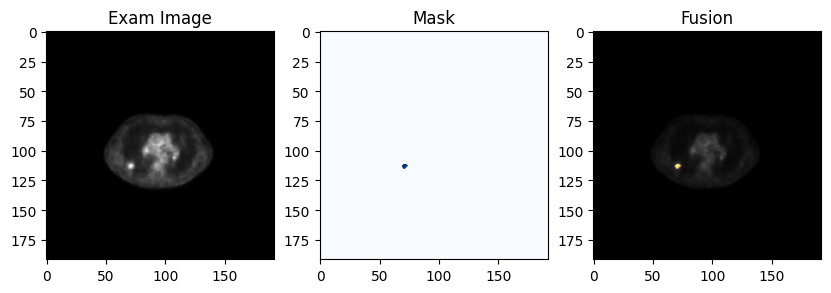

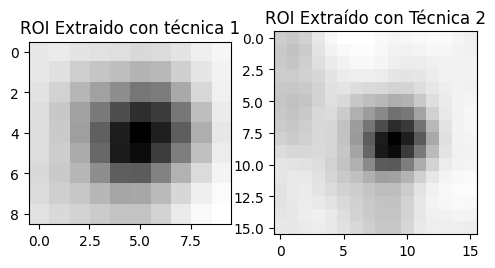

In [108]:
# Get the split keys (splits) of the dataset
split_keys = list(stanford_info.splits.keys())
random.shuffle(split_keys)
key = split_keys[0]

level = 50
window_width = 100
training_ds = stanford_dataset[key].shuffle(1)

# Iterate through the training dataset
img_exam, mask_exam = None, None
for patient_i_data in training_ds:
    img_exam, label, mask_exam, patient_id = patient_i_data['img_exam'], patient_i_data['label'], patient_i_data['mask_exam'], patient_i_data['patient_id']
    print(img_exam.shape, mask_exam.shape)
    print(label.numpy())
    print(patient_id.numpy().decode('utf-8'))
    break

visualizeImgMask(img_exam, mask_exam)
roi_extract = roiExtractionSize(img_exam, mask_exam)
roi_extract_size = roiExtractionSize(img_exam, mask_exam, total_size=16)

# Image 1
roi_extract_image = roi_extract
roi_extract_size_image = roi_extract_size

# Create a single figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(5, 4))  # 1 row, 2 columns

# Display Image 1 on the first subplot
axes[0].imshow(roi_extract_image, cmap='gray_r')
axes[0].set_title('ROI Extraido con técnica 1')
axes[1].imshow(roi_extract_size_image, cmap='gray_r')
axes[1].set_title('ROI Extraído con Técnica 2')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Visualizar datos de Santa María

(512, 512) (512, 512)
0
sm_017


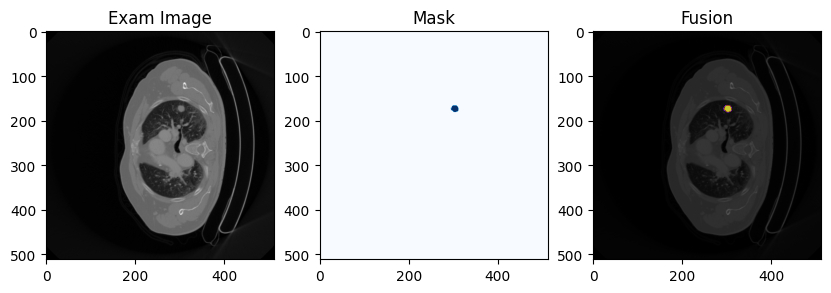

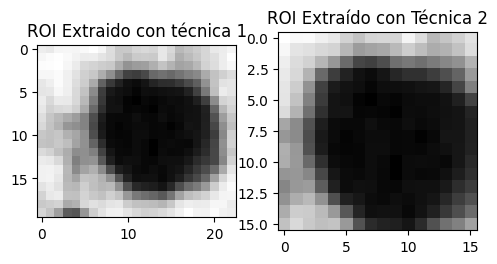

In [118]:
# Get the split keys (splits) of the dataset
split_keys = list(santamaria_info.splits.keys())
random.shuffle(split_keys)
key = split_keys[0]

level = 0
window_width = 0
training_ds = santamaria_dataset[key].shuffle(1)

# Iterate through the training dataset
img_exam, mask_exam = None, None
for patient_i_data in training_ds:
    img_exam, label, mask_exam, patient_id = patient_i_data['img_exam'], patient_i_data['label'], patient_i_data['mask_exam'], patient_i_data['patient_id']
    print(img_exam.shape, mask_exam.shape)
    print(label.numpy())
    print(patient_id.numpy().decode('utf-8'))
    break

visualizeImgMask(img_exam, mask_exam)
roi_extract = roiExtractionSize(img_exam, mask_exam)
roi_extract_size = roiExtractionSize(img_exam, mask_exam, total_size=16)

# Image 1
roi_extract_image = roi_extract
roi_extract_size_image = roi_extract_size

# Create a single figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(5, 4))  # 1 row, 2 columns

# Display Image 1 on the first subplot
axes[0].imshow(roi_extract_image, cmap='gray_r')
axes[0].set_title('ROI Extraido con técnica 1')
axes[1].imshow(roi_extract_size_image, cmap='gray_r')
axes[1].set_title('ROI Extraído con Técnica 2')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()